In [ ]:
%cd ../../src


In [1]:
from dataload import load
data = load()
from utils import get_p_types,get_relevant_relations,RDF_NUMBER_TYPES
#p_types = get_p_types(data)
rr = get_relevant_relations(data, RDF_NUMBER_TYPES)


c:\Users\Noctris\.virtualenvs\rdf-literal-preprocessing-20b3_M0v\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


loaded data dmg777k (57.15s).
pruned (9.633s).


In [ ]:
#Kullback-Leibler (KL) divergence
import math
import numpy as np
def adapted_kl_divergence(p_dist_a,p_dist_b, num_bins = 10):
    a_bin = np.histogram(p_dist_a.val,num_bins)[0]
    b_bin = np.histogram(p_dist_b.val,num_bins)[0]
    a_len = len(p_dist_a.val)
    b_len = len(p_dist_b.val)
    sum_l =0
    e = 0.1**10
    for i in range(len(a_bin)):
        sum_l += np.log((a_bin[i]/(b_bin[i]+e))+e)*a_bin[i]
    return round(b_len/a_len * sum_l , 5)

In [ ]:
from kgbench.load import Data
import torch
import pandas as pd
def get_relations_for_entites(data:Data,entities):
    df = data.triples
    df = df[torch.isin(df[:,0], torch.tensor(entities))]
    r, counts = torch.unique(df[:,1], return_counts=True)
    return pd.DataFrame({'r':r.numpy(),'count':counts.numpy()}).sort_values('count',ascending=False).reset_index(drop=True)

In [ ]:
from kgbench.load import Data


def bin_on_subpopulations_short(data:Data, base_relation:int, strategy = 'relations', max_depth=2):
    triples = data.triples
    relevant_triples = triples[triples[:,1] == base_relation]
    s_list = [[relevant_triples[:,0].numpy()]] # list with subject for each level of tree
    #get all subjects possessing relation 'base_relation'
    df = pd.DataFrame(relevant_triples[:,0], columns=['s']) 
    ## add val column containing numerical values coresponding to the s base_relation o triple, then mapped according to i2e[o]
    df['val'] = df.s.apply(lambda s: int(data.i2e[relevant_triples[relevant_triples[:,0]==s][0,2]][0]))

    r_counts = get_relations_for_entites(data, df.s)
    r_counts = r_counts[r_counts['r']!=base_relation] # here better logic is needed


    for i in range(max_depth-1):
        sub_s_list = [] 
        found = False
        j = 0
        while not found:
            sub_triples = triples[(triples[:,1] == base_relation) & torch.isin(triples[:,0], triples[triples[:,1] == r_counts.iloc[j].r][:,0])]
            proportion = len(sub_triples)/len(relevant_triples)
            #print(proportion)
            if proportion>0.95 or proportion <0.05:
                j += 1
            #df[df.s.isin(s_list[0][0])]['val']
            elif adapted_kl_divergence(df[df.s.isin(s_list[0][0])], df[df.s.isin(sub_triples[:,0].numpy())])<100:
                j+=1
            else:
                sub_s_list.append(sub_triples[:,0].numpy())
                #isin = torch.isin(relevant_triples[:,0], sub_triples[:,0])
                #neg = relevant_triples[~torch.isin(relevant_triples[:,0], sub_triples[:,0])]
                sub_s_list.append(relevant_triples[~torch.isin(relevant_triples[:,0], sub_triples[:,0])][:,0].numpy())
                found = True

                #print(len(df[df.s.isin(s_list[0][0])]))
                #print(df[df.s.isin(sub_triples[:,0].numpy())])

                

            #print('kl_div')
            #print(adapted_kl_divergence(df[df.s.isin(s_list[0][0])], df[df.s.isin(sub_triples[:,0].numpy())]))
            #if j >= len(r_counts)-1:
            #    found = True
            #if len(sub_triples)/len(relevant_triples)<0.01 or len(sub_triples)/len(triples)>0.99:
            #    i+=1 #skip to next
            #else:
            #    break

        s_list.append(sub_s_list)
        break

    #    else:
    #        found =True
        
    #sub_triples = triples[(triples[:,1] == base_relation) & torch.isin(triples[:,0], triples[triples[:,1] == r_counts.iloc[-1].r][:,0] )]# find overlapping
    #sub_s_list.append(sub_triples[:,0].numpy())
    #sub_s_list.append(triples[~torch.isin(triples[:,0],sub_triples[:,0])][:,0].numpy())
    #s_list.append(sub_s_list)
    return df, s_list

    #print(sub_triples)
    #sub_df = pd.DataFrame(sub_triples[:,0], columns=['s']) 
    #sub_df['val'] = sub_df.s.apply(lambda s: int(data.i2e[sub_triples[sub_triples[:,0]==s][0,2]][0]))

    #print(r_counts.iloc[0].r)
    ##print(sub)
    #print(len(sub))
    #print(len(df))
    #return sub_df


In [ ]:
from kgbench.load import Data


def bin_on_subpopulations(data:Data, base_relation:int, strategy = 'relations', max_depth=2):
    triples = data.triples
    relevant_triples = triples[triples[:,1] == base_relation]
    s_list = [[relevant_triples[:,0].numpy()]] # list with subject for each level of tree
    #get all subjects possessing relation 'base_relation'
    df = pd.DataFrame(relevant_triples[:,0], columns=['s']) 
    ## add val column containing numerical values coresponding to the s base_relation o triple, then mapped according to i2e[o]
    df['val'] = df.s.apply(lambda s: int(float(data.i2e[relevant_triples[relevant_triples[:,0]==s][0,2]][0])))

    r_counts = get_relations_for_entites(data, df.s)
    r_counts = r_counts[r_counts['r']!=base_relation] # here better logic is needed


    for i in range(1): # not yet implemented for deeper walks
        parent = s_list[0][0]
        print(len(parent))
        c_triples = triples[(triples[:,1] == base_relation) & torch.isin(triples[:,0], torch.tensor(parent) )]
        print(len(c_triples))
        print(c_triples)
        #child_reminder = parent
        
        sub_s_list = [] 
        #found = False
        #j = 0

        for j in range(len(r_counts)):
            #c_triples = triples[(triples[:,1] == base_relation) & torch.isin(triples[:,0], child_reminder )]

            sub_triples = triples[(triples[:,1] == base_relation) & (torch.isin(triples[:,0], triples[triples[:,1] == r_counts.iloc[j].r][:,0])) & (torch.isin(triples[:,0], c_triples[:,0]))]
            proportion = len(sub_triples)/len(parent)
            kl_div = adapted_kl_divergence(df[df.s.isin(c_triples[:,0].numpy())], df[df.s.isin(sub_triples[:,0].numpy())])
            
            print(f'j: {j} - prop: {proportion} - kl_div: {kl_div}')

            if proportion>0.95 or proportion <0.05:
                pass
            
            elif kl_div<300:
                pass
            else:
                #print("was here")
                print("added")
                sub_s_list.append(sub_triples[:,0].numpy())
                c_triples = c_triples[~torch.isin(c_triples[:,0],sub_triples[:,0])]

        sub_s_list.append(c_triples[:,0].numpy())
        if len(sub_s_list) >1:
            s_list.append(sub_s_list)
    return df, s_list


In [6]:
rr

[26, 2, 43]

In [7]:
df, s_list = bin_on_subpopulations(data,rr[-1])



1800
1800
tensor([[272102,     43,   3406],
        [272394,     43,   2701],
        [272516,     43,   2867],
        ...,
        [288824,     43,   2772],
        [288858,     43,   3248],
        [288866,     43,   2994]], dtype=torch.int32)
j: 0 - prop: 1.0 - kl_div: 0.0
j: 1 - prop: 1.0 - kl_div: 0.0
j: 2 - prop: 1.0 - kl_div: 0.0
j: 3 - prop: 1.0 - kl_div: 0.0
j: 4 - prop: 1.0 - kl_div: 0.0
j: 5 - prop: 1.0 - kl_div: 0.0
j: 6 - prop: 1.0 - kl_div: 0.0
j: 7 - prop: 1.0 - kl_div: 0.0
j: 8 - prop: 1.0 - kl_div: 0.0
j: 9 - prop: 1.0 - kl_div: 0.0
j: 10 - prop: 1.0 - kl_div: 0.0
j: 11 - prop: 1.0 - kl_div: 0.0
j: 12 - prop: 1.0 - kl_div: 0.0
j: 13 - prop: 0.4127777777777778 - kl_div: 4735.74484
added
j: 14 - prop: 0.0 - kl_div: 0.0
j: 15 - prop: 0.24944444444444444 - kl_div: 390.89206
added
j: 16 - prop: 0.08666666666666667 - kl_div: 286.30268
j: 17 - prop: 0.08666666666666667 - kl_div: 286.30268
j: 18 - prop: 0.020555555555555556 - kl_div: 128.43833
j: 19 - prop: 0.0211111111111111

In [8]:
for i in range(len(s_list[1])):
    for j in range(len(s_list[1])):
        akld = adapted_kl_divergence(df[df.s.isin(s_list[1][i])], df[df.s.isin(s_list[1][j])])
        print(f'kl for {i} to {j}: {akld}')

kl for 0 to 0: 0.0
kl for 0 to 1: 4567.92825
kl for 0 to 2: 1359.75033
kl for 1 to 0: 3535.77984
kl for 1 to 1: 0.0
kl for 1 to 2: 2385.01208
kl for 2 to 0: 2179.74698
kl for 2 to 1: 11788.22686
kl for 2 to 2: 0.0


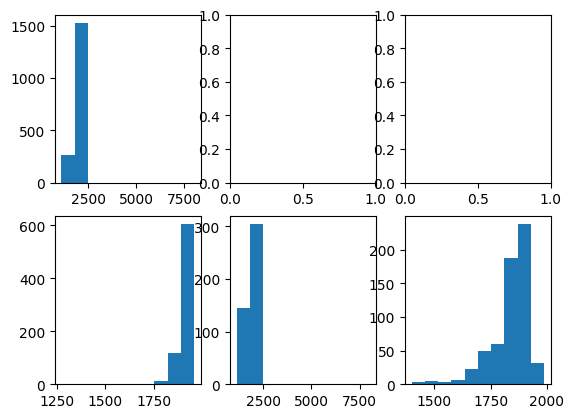

In [9]:
import matplotlib.pyplot as plt
fig, axis = plt.subplots(len(s_list), len(s_list[-1]))
for i in range(len(s_list)):
    for j in range(len(s_list[i])):
        axis[i,j].hist(df[df.s.isin(s_list[i][j])]['val'],bins=10)

In [10]:
torch.unique(data.triples[:,1])

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
        54, 55, 56, 57, 58, 59], dtype=torch.int32)

In [11]:
data.i2e[2701]

('1696', 'http://www.w3.org/2001/XMLSchema#gYear')

In [12]:
data.triples[(data.triples[:,0]== 272394) & (data.triples[:,1]== rr[2])]

tensor([[272394,     43,   2701]], dtype=torch.int32)

In [13]:
df

,s,val
0,272102,1884
1,272394,1696
2,272516,1739
3,272540,1650
4,272540,1650
...,...,...
1795,288766,1985
1796,288780,1980
1797,288824,1714
1798,288858,1850


In [2]:
import matplotlib.pyplot as plt

plt.hist(df.val)

NameError: name 'df' is not defined

In [7]:
from utils import  delete_triple

In [12]:
len(data.triples)

768728

In [51]:
data.triples

tensor([[130685,     28,  54795],
        [130685,     31, 201822],
        [130690,     28,  58948],
        ...,
        [271591,     31, 211084],
        [271593,     31, 211084],
        [271598,     31, 211084]], dtype=torch.int32)

In [53]:
data.triples.numpy()[0,0]

130685

In [54]:
int(data.triples[0,0].numpy())

130685

In [7]:
data.triples

tensor([[130685,     28,  54795],
        [130685,     31, 201822],
        [130690,     28,  58948],
        ...,
        [271591,     31, 211084],
        [271593,     31, 211084],
        [271598,     31, 211084]], dtype=torch.int32)

In [8]:

data.triples[0,2].numpy()

array(54795)

In [9]:
[2,3]
min([2,3])

2

In [28]:
for i in range(500):
    data = delete_triple(data,data.triples[0,0],data.triples[0,1],data.triples[0,2])


<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'tor

In [11]:
len(data.triples[(data.triples[:,0]==data.triples[0,0])])

2

In [12]:
data.i2e[2000]

('1462 HR', 'none')

In [13]:
data.e2i[data.i2e[2000]]

2000

In [31]:
data.num_relations

60

In [29]:
len(data.triples)

776554

In [48]:
rr = get_relevant_relations(data, RDF_NUMBER_TYPES)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\Noctris\.virtualenvs\rdf-literal-preprocessing-20b3_M0v\lib\site-packages\IPython\core\interactiveshell.py", line 3442, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\Noctris\AppData\Local\Temp\ipykernel_24508\3647624605.py", line 1, in <module>
    rr = get_relevant_relations(data, RDF_NUMBER_TYPES)
  File "e:\00_CODE\03_Master_Thesis\rdf-literal-preprocessing\src\utils\data_utils.py", line 85, in get_relevant_relations
  File "e:\00_CODE\03_Master_Thesis\rdf-literal-preprocessing\src\utils\data_utils.py", line 71, in get_p_types
    for triple in data.triples:
IndexError: list index out of range

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\Noctris\.virtualenvs\rdf-literal-preprocessing-20b3_M0v\lib\site-packages\IPython\core\interactiveshell.py", line 2057, in showtraceback
    stb = self.InteractiveTB.structured_tracebac

In [55]:
def delete_all_p_triples(data, pi):
    triples = data.triples
    for t in triples[triples[:,1] == pi]:
        data = delete_triple(data,t[0],t[1],t[2])

In [56]:
data.datatypes()

['iri',
 'none',
 '@es',
 '@fy',
 '@nl',
 '@nl-nl',
 '@pt',
 '@ru',
 'http://kgbench.info/dt#base64Image',
 'http://www.opengis.net/ont/geosparql#wktLiteral',
 'http://www.w3.org/2001/XMLSchema#anyURI',
 'http://www.w3.org/2001/XMLSchema#boolean',
 'http://www.w3.org/2001/XMLSchema#gYear',
 'http://www.w3.org/2001/XMLSchema#nonNegativeInteger',
 'http://www.w3.org/2001/XMLSchema#positiveInteger']

In [57]:
for r in rr:
    delete_all_p_triples(data,r)

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'tor

TypeError: list indices must be integers or slices, not str

In [11]:
data.datatypes()

['iri',
 'none',
 '@es',
 '@fy',
 '@nl',
 '@nl-nl',
 '@pt',
 '@ru',
 'http://kgbench.info/dt#base64Image',
 'http://www.opengis.net/ont/geosparql#wktLiteral',
 'http://www.w3.org/2001/XMLSchema#anyURI',
 'http://www.w3.org/2001/XMLSchema#boolean',
 'http://www.w3.org/2001/XMLSchema#gYear',
 'http://www.w3.org/2001/XMLSchema#nonNegativeInteger',
 'http://www.w3.org/2001/XMLSchema#positiveInteger']

In [37]:
data.r2i["http://www.w3.org/2001/XMLSchema#positiveInteger"]


KeyError: 'http://www.w3.org/2001/XMLSchema#positiveInteger'

In [39]:
rr

[26, 2, 43]

In [6]:
len(data.triples[data.triples[:,1]== 2])

8396

In [4]:
rr

[26, 2, 43]

In [10]:
data.i2r[2]

'http://dbpedia.org/ontology/location'

In [9]:
i=0
while("http://dbpedia.org/ontology/codeNationalMonument" in data.r2i):
    if i%200:
        print(i)
    t = data.triples[data.triples[:,1]== data.r2i["http://dbpedia.org/ontology/codeNationalMonument"]]
    data = delete_triple(data,t[0,0], t[0,1], t[0,2] )


TypeError: list indices must be integers or slices, not str

In [13]:
data.triples

tensor([[130685,     28,  54795],
        [130685,     31, 201822],
        [130690,     28,  58948],
        ...,
        [271591,     31, 211084],
        [271593,     31, 211084],
        [271598,     31, 211084]], dtype=torch.int32)

In [16]:
triples = data.triples
triples

tensor([[130685,     28,  54795],
        [130685,     31, 201822],
        [130690,     28,  58948],
        ...,
        [271591,     31, 211084],
        [271593,     31, 211084],
        [271598,     31, 211084]], dtype=torch.int32)

In [25]:
filtered = triples[~(triples[:,1]==rr[0])]

In [28]:
import torch

In [55]:
s = torch.unique(filtered[:,2])

In [40]:
st = torch.unique(triples[:,2])

In [41]:
neg_filter =  st[~(torch.isin(st, s))]


In [45]:
for n in neg_filter.numpy():
    print(n)
    break

417


In [60]:
filtered[:,2]

tensor([ 54795, 201822,  58948,  ..., 211084, 211084, 211084],
       dtype=torch.int32)

In [64]:
torch.unique(torch.cat([filtered[:,0],filtered[:,2]])) 

tensor([     0,      1,      2,  ..., 341267, 341268, 341269],
       dtype=torch.int32)

In [73]:
def delete_r(data:Data, r):
    # get subset data
    filtered = data.triples[~(data.triples[:,1]==r)]
    # get neg e filter
    base_e_unique = torch.unique(torch.cat([data.triples[:,0],data.triples[:,2]])) 
    filtered_e_unique = torch.unique(torch.cat([filtered[:,0],filtered[:,2]])) 
    neg_e_filter =  base_e_unique[~(torch.isin(base_e_unique, filtered_e_unique))]

    #get neg r filter
    base_r_unique = torch.unique(data.triples[:,1])
    filtered_r_unique = torch.unique(filtered[:,1])
    neg_r_filter =  base_r_unique[~(torch.isin(base_r_unique, filtered_r_unique))]

    #create new e mapping
    new_e2i = {}
    new_i2e = []

    for i in range(len(data.i2e)):
        if i not in neg_e_filter.numpy():
            new_e2i[data.i2e[i]] = len(new_i2e)
            new_i2e.append(data.i2e[i])

    #create new r mapping
    new_r2i = {}
    new_i2r = []

    for i in range(len(data.i2r)):
        if i not in neg_r_filter.numpy():
            new_r2i[data.i2r[i]] = len(new_i2r)
            new_i2r.append(data.i2r[i])

    # apply new mapping for triples
    for t in filtered:
        t[0] = torch.tensor(new_e2i[data.i2e[t[0].numpy()]], dtype=torch.int32)
        t[1] = torch.tensor(new_r2i[data.i2r[t[1].numpy()]], dtype=torch.int32)
        t[2] = torch.tensor(new_e2i[data.i2e[t[2].numpy()]], dtype=torch.int32)

    #update metedata
    data.num_entities = len(new_i2e)
    data.num_relations = len(new_i2r)

    #update data
    data.triples = filtered
    data.i2e = new_i2e
    data.e2i = new_e2i
    data.i2r = new_i2r
    data.r2i = new_r2i
    
    return data



In [80]:
rr = get_relevant_relations(data,RDF_NUMBER_TYPES)

In [81]:
rr

[41]

In [82]:
print(data.num_entities)
print(data.num_relations)
data = delete_r(data, rr[0])
print(data.num_entities)
print(data.num_relations)

332379
58
332089
57


In [75]:
print(data.num_entities)
print(data.num_relations)

340775
59


In [51]:
len(neg_filter)

495

In [50]:
len(data.i2e)

341270

In [19]:
triples

tensor([[130685,     28,  54795],
        [130685,     31, 201822],
        [130690,     28,  58948],
        ...,
        [271591,     31, 211084],
        [271593,     31, 211084],
        [271598,     31, 211084]], dtype=torch.int32)

In [92]:
data.triples[torch.isin(data.triples[:,0], torch.tensor([121501,280064]))]

tensor([[280064,      0,  43028],
        [280064,     26,  46719],
        [280064,     29, 192641],
        [280064,     29, 192642],
        [121501,     29, 192641]], dtype=torch.int32)

In [88]:
torch.unique(data.triples[:,0])

tensor([121500, 121501, 121502,  ..., 280064, 280065, 280066],
       dtype=torch.int32)